<a href="https://colab.research.google.com/github/mddsayemm/Precision-Farming/blob/main/PlantTest(No%20Class).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-1-e55e5fe3c28c>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Image: /content/drive/MyDrive/testforcomp/327.png, Predicted Class ID: 7, Predicted Class Name: Maize
Image: /content/drive/MyDrive/testforcomp/325.png, Predicted Class ID: 7, Predicted Class Name: Maize
Image: /content/drive/MyDrive/testforcomp/326.png, Predicted Class ID: 7, Predicted Class Name: Maize
Image: /content/drive/MyDrive/testforcomp/324.png, Predicted Class ID: 7, Predicted Class Name: Maize
Image: /content/drive/MyDrive/testforcomp/323.png, Predicted Class ID: 7, Predicted Class Name: Maize
Image: /content/drive/MyDrive/testforcomp/115.png, Predicted Class ID: 6, Predicted Class Name: Loose Silky-bent
Image: /content/drive/MyDrive/testforcomp/175.png, Predicted Class ID: 6, Predicted Class Name: Loose Silky-bent
Image: /content/drive/MyDrive/testforcomp/082.png, Predicted Class ID: 6, Predicted Class Name: Loose Silky-bent
Image: /content/drive/MyDrive/testforcomp/110.png, Predicted Class ID: 0, Predicted Class Name: Black-grass
Image: /content/drive/MyDrive/testforcomp/1

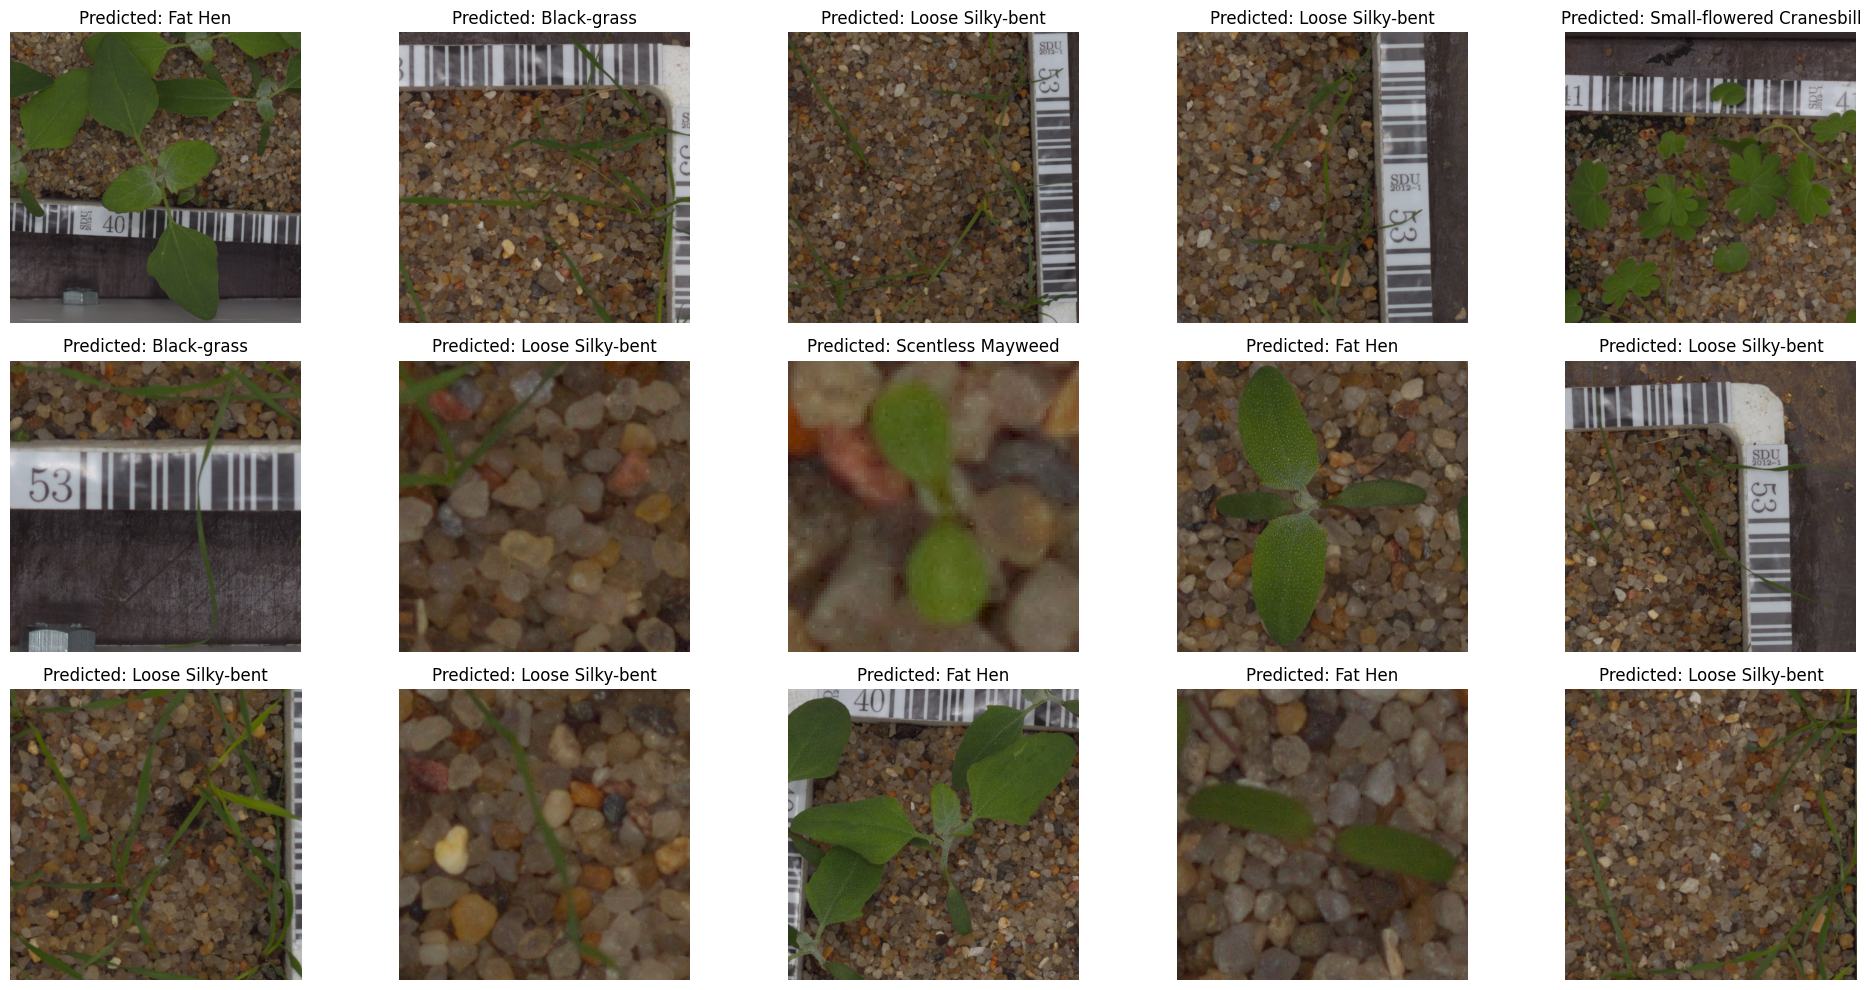

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Path to your dataset folder
dataset_path = "/content/drive/MyDrive/testforcomp"

# Ensure the dataset folder exists
assert os.path.exists(dataset_path), "Dataset folder does not exist!"

# Custom Dataset for Loading Images Without Classes
class CustomImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = [
            os.path.join(folder_path, fname)
            for fname in os.listdir(folder_path)
            if fname.lower().endswith(('jpg', 'jpeg', 'png'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, image_path

# Data transformations (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create the custom dataset
test_dataset = CustomImageDataset(dataset_path, transform=transform)

# Create a DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the trained model
model_path = "/content/drive/MyDrive/plant_classifier_resnet18.pth"  # Update the path as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model architecture (match the saved model)
model = models.resnet18(pretrained=False)
num_classes = 12  # Update to match the number of classes used during training
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

# Class names (update with actual class names used during training)
class_names = [
    'Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen',
    'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherd’s Purse',
    'Small-flowered Cranesbill', 'Sugar beet'
]

# Function to perform inference on the dataset
def evaluate_model_with_names(model, data_loader, device):
    predictions = []
    image_paths = []

    with torch.no_grad():
        for inputs, paths in tqdm(data_loader, desc="Testing Progress"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            image_paths.extend(paths)

    return predictions, image_paths

# Evaluate the model on the test dataset
predictions, image_paths = evaluate_model_with_names(model, test_loader, device)

# Print results with class names
for img_path, pred in zip(image_paths, predictions):
    print(f"Image: {img_path}, Predicted Class ID: {pred}, Predicted Class Name: {class_names[pred]}")

# Visualize 15 random images with their predictions
def visualize_predictions(image_paths, predictions, class_names, num_images=15):
    plt.figure(figsize=(20, 10))

    # Select 15 random images
    indices = random.sample(range(len(image_paths)), min(num_images, len(image_paths)))

    for i, idx in enumerate(indices):
        img_path = image_paths[idx]
        pred_class = class_names[predictions[idx]]

        # Load and plot the image
        img = Image.open(img_path).convert("RGB")
        plt.subplot(3, 5, i + 1)  # 3 rows, 5 columns
        plt.imshow(img)
        plt.title(f"Predicted: {pred_class}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_predictions(image_paths, predictions, class_names)
